# Описание проекта

Перед нами стоит задача от нефтедобывающей компании: определить регион, в котором наиболее эффективно и экономически целесообразно проводить разработку новых скважин.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищем месторождения, для каждого определяем значения признаков;
- Строим модель и оцениваем объём запасов;
- Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия:

1. При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
2. Бюджет на разработку скважин в регионе — 10 млрд рублей.
3. Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
4. Вероятность убытков в регионах должна быть меньше 2.5%. Среди подходящих условию выбирают регион с наибольшей средней прибылью.

Разделим наш проект на следующие этапы:

### [**Часть 1.** Загрузка и подготовка данных](#step_1)

### [**Часть 2.** Обучение и проверка модели](#step_2)

### [**Часть 3.** Подготовка к расчёту прибыли](#step_3)

### [**Часть 4.** Расчёт прибыли и рисков](#step_4)

### [**Часть 5.** Общий вывод](#step_5)

In [1]:
#импорт всех библиотек, используемых в проекте
import pandas as pd
from IPython.display import display
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(palette="muted")

# 1. Загрузка и подготовка данных <a id='step_1'></a> 

В первую очередь откроем и рассмотрим исходные данные по трем регионам. Сохраним датафреймы как `gd_0`, `gd_1` и `gd_2` соответственно.

In [3]:
gd_0 = pd.read_csv('geo_data_0.csv')
gd_1 = pd.read_csv('geo_data_1.csv')
gd_2 = pd.read_csv('geo_data_2.csv')

In [4]:
def info(data):
    """
    Функция пробегает по признакам датафрейма и если тип у признака object, то смотрит уникальные значения, 
    в противном случае оценивается распределение
    """    
    for column in data.columns:
    
        if data[column].dtype == 'object':
            
            print(column)
            print(data[column].unique())
            print()
            print(data[column].describe())
            print()
        
        else:
            
            print(column)
            print()
            print(data[column].describe())
            print()
            plt.figure(figsize = (12,8))
            bins = int(abs(round(data[column].max() - data[column].min())) / 1000)
            sns.distplot(data[column], bins=100, hist_kws={'alpha':1}, kde=False) #Построение распределения
            plt.title('Распределение ' + column)
            plt.xlabel(column)
            plt.ylabel('count')
            plt.show()
        
        last_column = column

id
['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']

count     100000
unique     99990
top        74z30
freq           2
Name: id, dtype: object

f0

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64



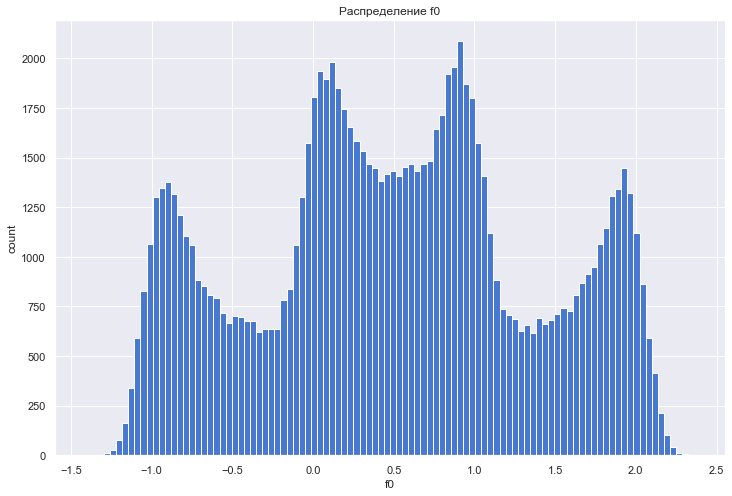

f1

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64



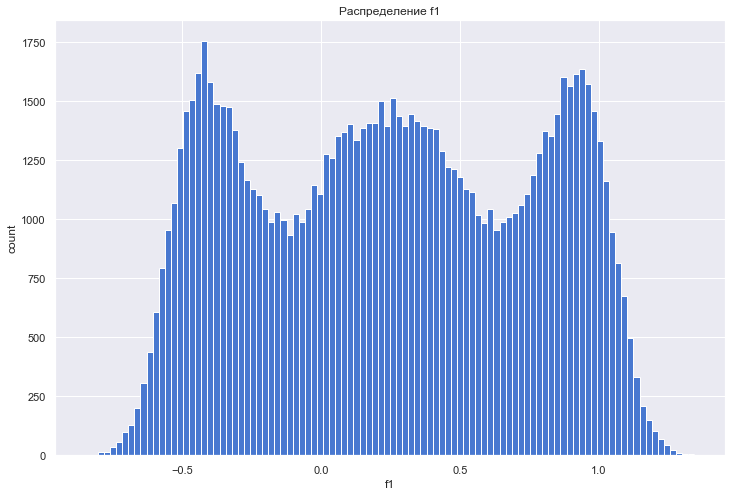

f2

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64



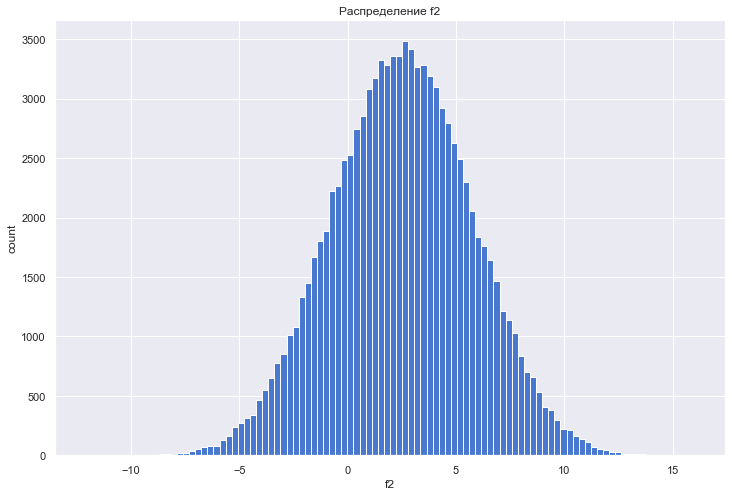

product

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64



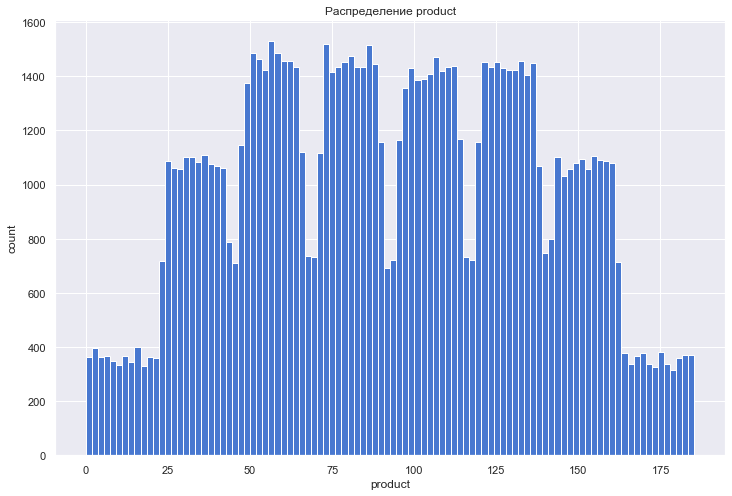

In [5]:
info(gd_0)

id
['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']

count     100000
unique     99996
top        wt4Uk
freq           2
Name: id, dtype: object

f0

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64



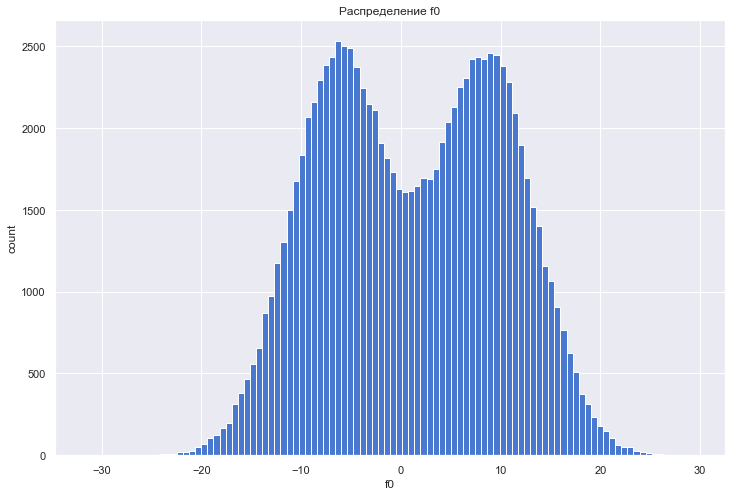

f1

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64



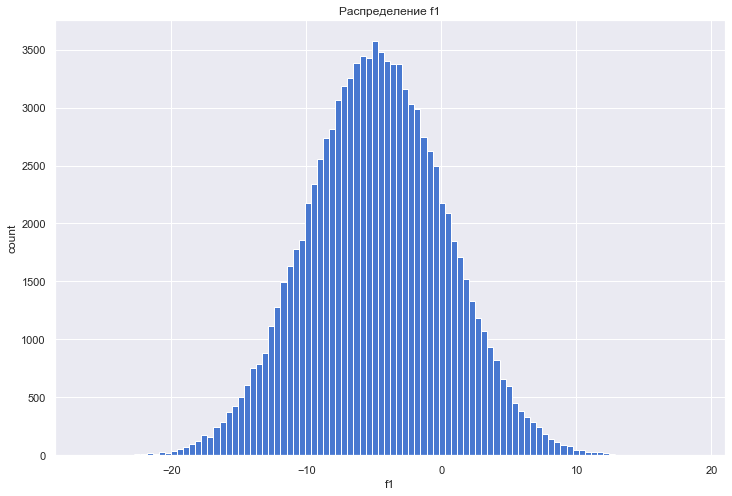

f2

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64



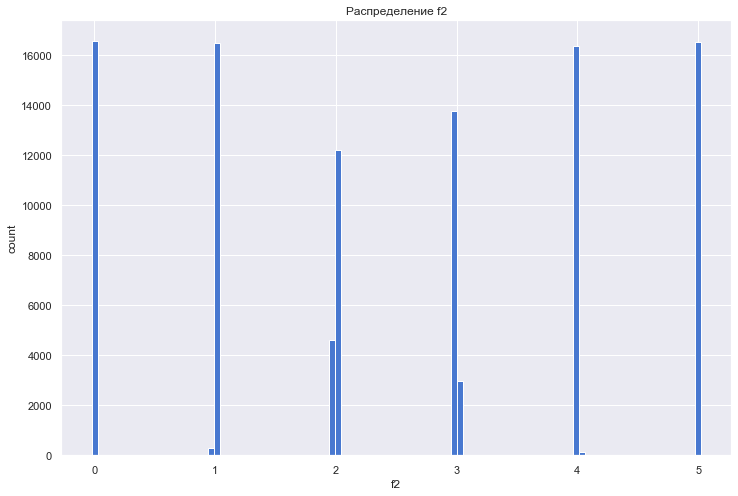

product

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64



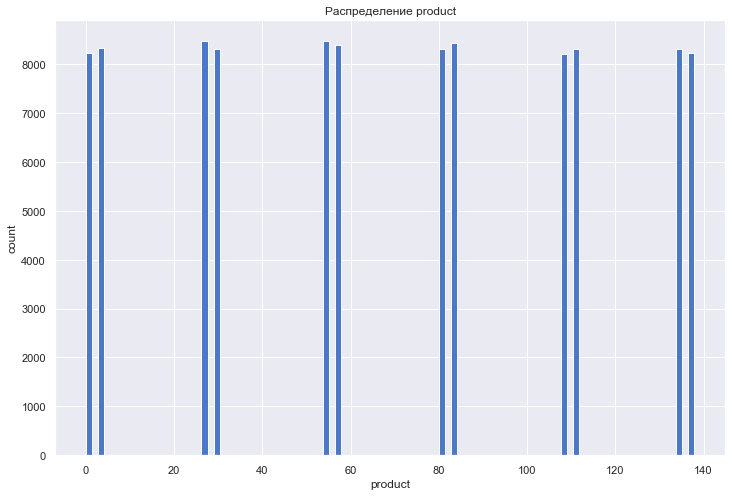

In [6]:
info(gd_1)

id
['fwXo0' 'WJtFt' 'ovLUW' ... 'tKPY3' 'nmxp2' 'V9kWn']

count     100000
unique     99996
top        VF7Jo
freq           2
Name: id, dtype: object

f0

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64



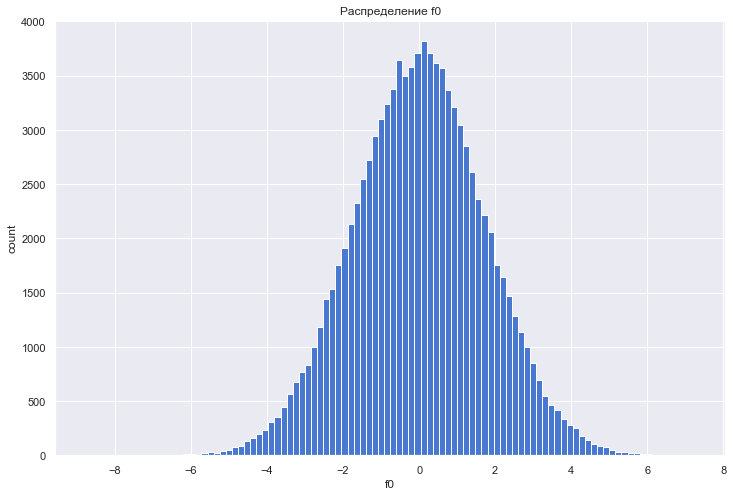

f1

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64



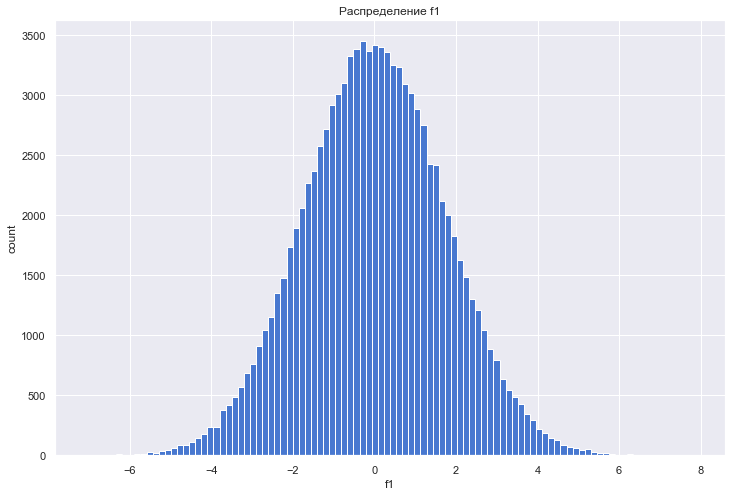

f2

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64



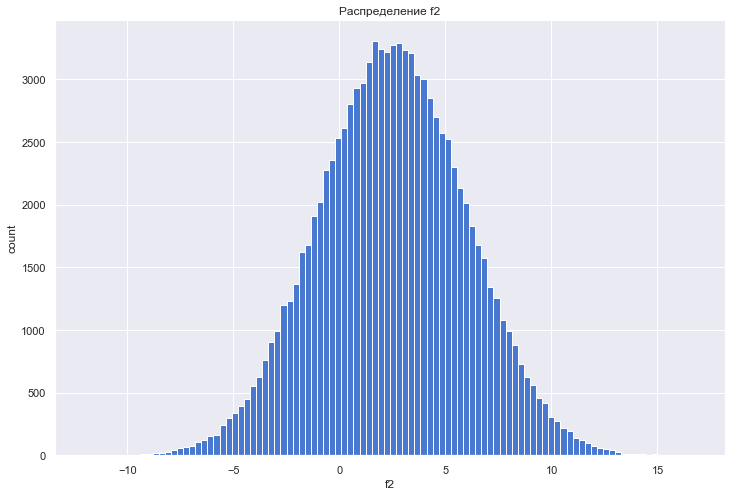

product

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64



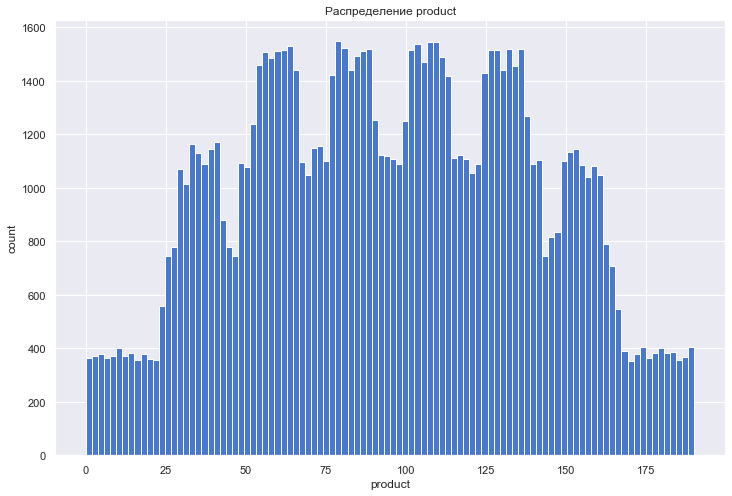

In [7]:
info(gd_2)

Во всех таблицах 100 000 строк, данные всех трех признаков распределены симметрично относительно медианы, кроме признака f2 во втором регионе. Также во втором регионе распределение объема запасов в скважинах очень дискретно. Все 3 признака имеют разный масштаб, при обучении модели проведем нормировку. Не смотря на то, что имеется от 4 до 10 повторений в столбце `id`, полных дубликатов ни в одном регионе не наблюдается. 

В рамках подготовки данных разобъём их на обучающие и валидационные выборки. Поскольку для построения модели столбец с идентификатором скважин нам не понадобится, записывать его в признаки мы не будем.

In [8]:
def preparing(data):
    """
    Функция выделения из датафрейма обучающей и валидационной выборок, с разделением на целевой и обычные признаки
    """ 
    features = data.drop(['product', 'id'], axis = 1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=357)
        
    return features_train, features_valid, target_train, target_valid

In [9]:
gd_0 = gd_0.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()
gd_1 = gd_1.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()
gd_2 = gd_2.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()
ft_0, fv_0, tt_0, tv_0 = preparing(gd_0)
ft_1, fv_1, tt_1, tv_1 = preparing(gd_1)
ft_2, fv_2, tt_2, tv_2 = preparing(gd_2)

Данные полностью готовы к обучению моделей и изучению регионов.

# 2. Обучение и проверка модели <a id='step_2'></a> 

Для каждого региона обучим модель линейной регрессии, с учетом необходимости нормализации данных. Затем сформируем на валидационной выборке предсказания, средний предсказанный запас сырья и корень средней квадратичной ошибки модели. Построим графики распредления целевых данных и сравним их с распределением предсказанных значений.

In [15]:
def teaching_LR(features_train, target_train, features_valid, target_valid, title):
    """
    Функция обучения модели, формирования списка предсказаний и рассчета квадратного корня из средней квадратичной ошибки
    """ 
    model = LinearRegression(normalize = True)
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions) ** (1/2)
    
    print('RMSE:', rmse)
    print('Предсказанный средний запас сырья:', predictions.mean())
    print('Истинный средний запас сырья:     ', target_valid.mean())

    plt.figure(figsize=(12,8))
    sns.distplot(target_valid, bins=100, hist_kws={'alpha':0.6}, color = 'dodgerblue', label = "Target", kde=False)
    sns.distplot(predictions, bins=100, hist_kws={'alpha':0.7}, color = 'orange', label = "Predict", kde=False)    
    
    plt.title('Распределение скважин по запасам '+title)
    plt.xlabel('Объем запасов нефти в скважине, тыс. баррелей')
    plt.ylabel("Количество скважин")
    plt.legend()
    plt.show()
    
    
    return model, predictions, rmse

Первый регион

RMSE: 37.79365772616117
Предсказанный средний запас сырья: 92.39166236991228
Истинный средний запас сырья:      92.33854064795563


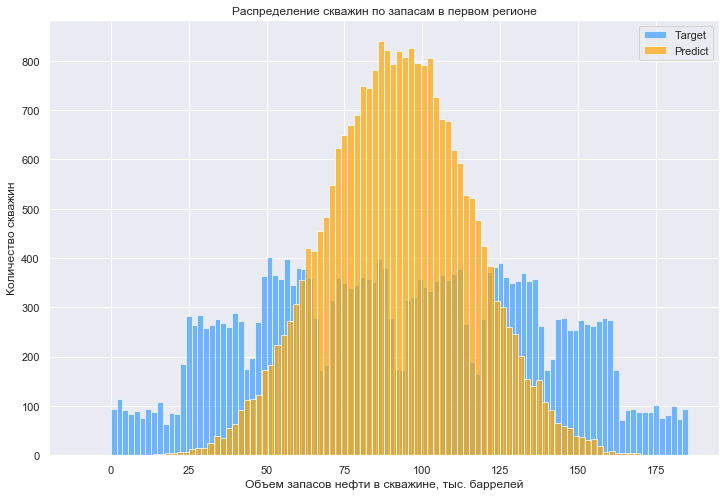

In [17]:
print('Первый регион')
print()
model_0, predictions_0, rmse_0 = teaching_LR(ft_0, tt_0, fv_0, tv_0, 'в первом регионе')

Второй регион

RMSE: 0.8843411873411612
Предсказанный средний запас сырья: 69.11339833258917
Истинный средний запас сырья:      69.12151351571723


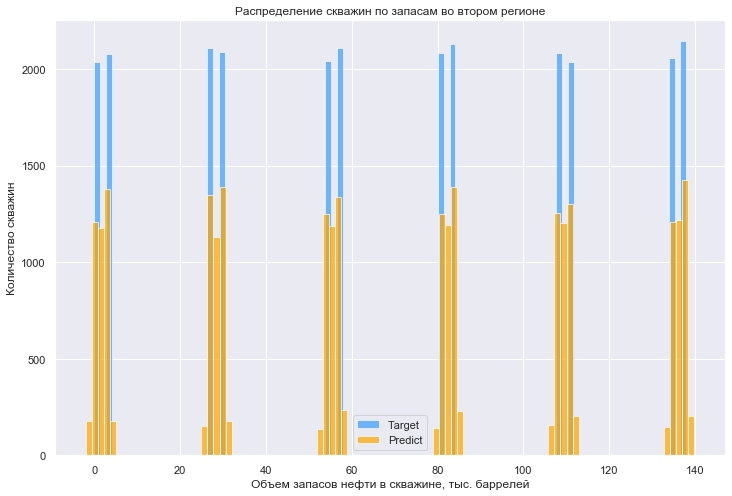

In [19]:
print('Второй регион')
print()
model_1, predictions_1, rmse_1 = teaching_LR(ft_1, tt_1, fv_1, tv_1, 'во втором регионе')

Третий регион

RMSE: 40.10672482504716
Предсказанный средний запас сырья: 94.94649182447688
Истинный средний запас сырья:      94.9627276849282


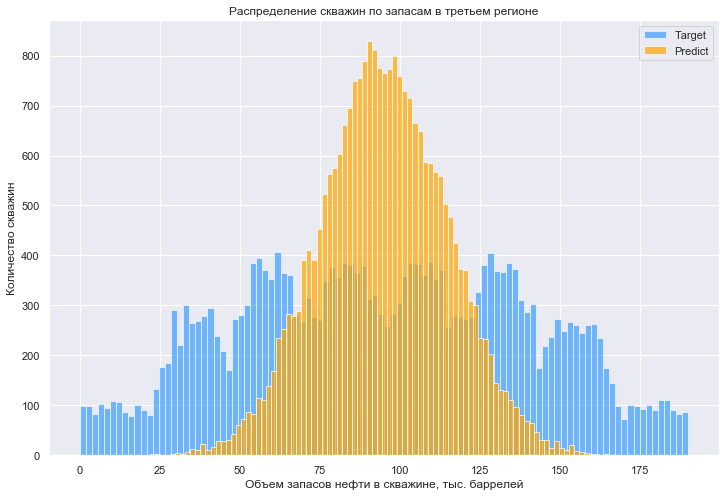

In [21]:
print('Третий регион')
print()
model_2, predictions_2, rmse_2 = teaching_LR(ft_2, tt_2, fv_2, tv_2, 'в третьем регионе')

Средний запас для всех моделей достаточно точно совпадает со средним запасом, указанным в исходных данных. Наименьший RMSE у модели второго региона, около 0.9 тыс. баррелей, что говорит о достаточно высокой точности модели. В первом и третьем регионе RMSE уже значительно выше около 38 и 40 тыс. баррелей соответственно. На графиках видно что такой разброс обусловлен характером распределения данных. В исходных данных распределение имеет многопиковый, симметричный относительно медианы характер, а распределение предсказаных значений имеет вид нормального распределения. В то время, для второго региона модель достаточно точно предсказала значения, рассчитав их вблизи целевых параметров, характеры распределений очень схожи.

# 3. Подготовка к расчёту прибыли <a id='step_3'></a> 

В рамках подготовки к расчёту прибыли создадим отдельные переменные для необходимого количества скважин `well_count`, имеющегося у нас бюджета `budget`, стоимости тысячи баррелей нефти `cost_of_thousand_barrels`. Рассчитаем стоимость разработки одной скважины, которая будет являться условием безубыточности скважины, а также объем нефти в скважине, необходимый для безубыточной добычи. 

Затем, подготовим функцию `revenue` для рассчета прибыли, которая будет отбирать необходимое количество скважин с максимальными предсказанными значениями запасов нефти, суммировать целевое значение объема сырья, соответствующее этим предсказаниям и рассчитывать прибыль для этого объема путём умножения его на стоимость тысячи баррелей нефти и вычитания из полученного значения затраченного на все скважины бюджета.

In [22]:
well_count = 200
budget = 10 ** 10
cost_of_thousand_barrels = 450000

print("Стоимость разработки одной скважины:", int(budget / well_count / (10 ** 6)), "млн. рублей")

print("Объем запасов нефти в скважине, необходимый для безубыточной добычи: {:.2f}".format(budget / well_count / cost_of_thousand_barrels), "тыс. баррелей")

Стоимость разработки одной скважины: 50 млн. рублей
Объем запасов нефти в скважине, необходимый для безубыточной добычи: 111.11 тыс. баррелей


In [23]:
def revenue(target, predictions):
    preds_sorted = predictions.sort_values(ascending=False)
    selected = target[preds_sorted.index][:well_count]
    return cost_of_thousand_barrels * selected.sum() - budget

Стоимость разработки одной скважины при бюджете в 10 млрд. рублей и необходимости разработки 200 скважин составляет 50 млн. рублей. Безубыточный запас нефти в каждой скважине составляет от 111.(1) тыс. баррелей нефти. Это больше, чем среднее содержание нефти в скважинах в каждом регионе. Однако, при условии того что среднее посчитано для 25000 скважин, найти среди них 200 содержащих более 111.1 тыс баррелей нефти выглядит более чем возможным.

# 4. Расчёт прибыли и рисков <a id='step_4'></a> 

Для рассчета прибыли в каждом регионе напишем функцию, которая будет с помощью метода Bootstrap создавать тысячу случайных выборок в 500 скважин, определять среди них 200 наиболее прибыльных скважин и считать их суммарную прибыль, которая будет записываться в массив прибылей для региона. Затем, функция будет определять среднюю прибыль в регионе, 95%-й доверительный интервал прибыли, а также оценивать риск убытков при разработке в данном регионе, путем подсчета отношения количества убыточных вариантов, ко всем возможным.

In [24]:
def bstrap(target, predictions, interval):
    
    predictions = pd.Series(predictions)
    target = target.reset_index(drop = True)
    
    state = np.random.RandomState(357)
    values = []
    
    for i in range(1000):
        target_subsample = target.sample(n = 500, replace = True, random_state = state)
        preds_subsample = predictions[target_subsample.index]  
    
        values.append(revenue(target_subsample, preds_subsample))
    
    values = pd.Series(values)
   
    mean = values.mean()
    
    confidence_interval = st.t.interval(interval, len(values) - 1, mean, values.sem())
    confidence_interval = list(confidence_interval)
    confidence_interval[0] = int(round(confidence_interval[0] / (10 ** 6)) * (10 ** 6))
    confidence_interval[1] = int(round(confidence_interval[1] / (10 ** 6)) * (10 ** 6))
    
    values_loss = values[values < 0.0]
    risk = len(values_loss) / len(values)
    
    confidence_interval_2 = (values.quantile(0.025), values.quantile(0.975))
    confidence_interval_2 = list(confidence_interval_2)
    confidence_interval_2[0] = int(round(confidence_interval_2[0] / (10 ** 6)) * (10 ** 6))
    confidence_interval_2[1] = int(round(confidence_interval_2[1] / (10 ** 6)) * (10 ** 6))
    
    print('Cредняя прибыль:                        {:.1f}'.format(mean / (10 ** 6)), ' млн. рублей')
    print('95%-й доверительный интервал среднего: ', confidence_interval)
    print('95%-й доверительный интервал:          ', confidence_interval_2)
    print("Риск убытков:                           {:.1%}".format(risk))

In [25]:
dov_interval = 0.95
print('Первый регион:')
bstrap(tv_0, predictions_0, dov_interval)
print()
print('Второй регион:')
bstrap(tv_1, predictions_1, dov_interval)
print()
print('Третий регион:')
bstrap(tv_2, predictions_2, dov_interval)

Первый регион:
Cредняя прибыль:                        410.2  млн. рублей
95%-й доверительный интервал среднего:  [393000000, 427000000]
95%-й доверительный интервал:           [-131000000, 924000000]
Риск убытков:                           6.3%

Второй регион:
Cредняя прибыль:                        553.7  млн. рублей
95%-й доверительный интервал среднего:  [540000000, 567000000]
95%-й доверительный интервал:           [133000000, 974000000]
Риск убытков:                           0.5%

Третий регион:
Cредняя прибыль:                        355.7  млн. рублей
95%-й доверительный интервал среднего:  [338000000, 373000000]
95%-й доверительный интервал:           [-214000000, 867000000]
Риск убытков:                           10.7%


По результатам расчетов второй регион имеет наибольшую среднюю прибыль и наименьший риск убытков, всего 0,5%. При том, что по условию поставленной задачи нам нужен регион, риск убытков в котором не превышает 2,5% мы можем предложить проводить разработку 200 скважин во втором регионе, как наименее рисковом и наиболее прибыльном.

По видимому, несмотря на то, что в этом регионе средний запас сырья был определен наименьшим, рассчитаная наивысшая прибыль и наименьшие риски обусловлены тем, что модель в данном регионе наиболее точно предсказывала запасы нефти в скважинах. Вполне возможно, что более точно предсказывающие модели для 1 и 3 региона дали бы большие значения прибыли в этих регионах.

# 5. Выводы <a id='step_5'></a> 

В данной задаче мы решали задачу выбора одного из трех регионов, в котором компании "ГлавРосГосНефть" наиболее выгодно пробурить 200 скважин, при бюджете в 10 млрд. рублей. Для этого мы:
1. Изучили и подготовили предоставленные нам данные о пробах нефти, взятых в различных точках в этих трёх регионах.
2. Построили модели для предсказания объема запасов нефти в новых скважинах
3. Выбирали скважины с самыми высокими оценками предсказанных значений запасов, на основе этих предсказаний рассчитывали среднюю прогнозируемую прибыль и оценивали риски.

По рассчетам получены следующие показатели для регионов:
1. Прибыль: 410.2 млн. рублей. Риск убытков: 6.3%
2. Прибыль: 553.7 млн. рублей. Риск убытков: 0.5%
3. Прибыль: 355.7 млн. рублей. Риск убытков: 10.7%

Таким образом, мы рекомендуем проводить разработку скважин во втором регионе.